In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from shutil import rmtree
from os.path import isdir
from os import mkdir
from sympy import solve, symbols, Eq
from sympy.physics.units import kilo, milli
from sympy.physics.units import convert_to
from sympy.physics.units import ohms, amperes, volts
import ltspice
import platform
import ahkab
import pylab as plt
from IPython import get_ipython


W: Locale appears not set! please export LANG="en_US.UTF-8" or equivalent, 
W: or ahkab's unicode support is broken.



  # Objetivo del laboratorio
  El objetivo de la presenta práctica es conocer el estándar de simulación de circuitos [SPICE](http://bwrcs.eecs.berkeley.edu/Classes/IcBook/SPICE) y realizar pequeñas simulaciones en corriente continua con el mismo. SPICE es una forma elegante y sencilla de codificar circuitos eléctricos de manera que puedan ser procesados por un ordenador. Mediante un sencillo lenguaje podemos definir resistencias, fuentes de alimentación, etc., las conexiones entre ellos y los resultados que deseamos obtener.

  # El estándar SPICE
  **SPICE** es una abreviabiación de *Simulation Program with Integrated Circtuit Emphasis*.
  Se trata básicamente de un método estándar para describir circuitos usando texto plano en
  lugar de una representación gráfica (o *esquemática*). A esta descripción en texto se
  la llama también **netlist** y básicamente se corresponde con la *lista* de los componentes del circuito y cómo estos están conectados entre sí, es decir, de los nodos de unión.
  Los ficheros netlist pueden tener extensiones `.cir`, `.net`, `.ckt`, ó `.sp` y es muy común encontrárselos con cualquiera de estas.

  Existen en el mercado muchas variantes (intérpretes) de Spice, aunque el original fue descrito
  en la Universidad de Berkeley. En la lista de intérpretes de Spice tenemos desde esfuerzos y proyectos comerciales hasta *open source* y regidos por distintas comunidades de usuarios y programadores.


 > **Pregunta:** Enumera todos los intérprete de Spice que puedas encontrar. Crea una tabla en Markdown con varias columnas (para el nombre, fabricante, versión actual, licencia y alguna característica sobresaliente). Aquí tienes un ejemplo del que puedes partir y seguir completando:

 | Intérprete  | Licencia | Fabricante             | Características  |
 | ----------- | -------- | ---------------------- | ---------------- |
 | Ahkab       | GPL      | Giuseppe Venturini     | Basado en Python |
 | LTspice     |          |                        |                  |
 | PSpice      |          |                        |                  |
 | Orcad       |          |                        |                  |
 | ngspice     |          |                        |                  |
 | macspice    |          |                        |                  |
 | spice       |          |                        |                  |
 | Multisim    |          | National Instruments   |                  |




  > **Pregunta:** ¿Qué comparación puedes efectuar entre C y Spice como estándares (lenguajes) y sus respectivas implementaciones en software? ¿Qué implementaciones reales (compiladores) del lenguaje C conoces?

  ## Elementos de un netlist
  Como acabamos de comentar, un netlist se corresponde con la codificación de los elementos electrónicos de un circuito y las uniones entre los mismos. Veamos con más concreción qué partes y secciones lo componen.

  ## Comentarios

  La primera línea de un netlist se corresponderá siempre con un comentario. A partir de esta línea se pueden introducir más comentarios pero tienen que ir siempre precedidos de un `*`. Ejemplo:

  ```spice
  Mi primer circuito
  * Otro comentario
  * más comentarios
  *
  ```

  ## Dispositivos básicos de un circuito
  Los elementos de un netlist son los mismos que encontramos en cualquier circuito eléctrico sencillo,
  tales como resistencias, **condensadores**, **bobinas**, **interruptores**, **hilos** y **fuentes** de alimentación.
  Para distinguir uno de otro, se reserva una letra característica: `V` para fuentes de alimentación, `R` para resistencias, `C` para condensadores y `L` para bobinas. También es posible usar estas letras en su versión en minúscula (`r`, `v`, `c`, `l`, etc.).
  Después de esta letra característica se puede sufijar cualquier texto para diferenciar un elemento de otro (números, letras, palabras, etc.). Ejemplo:

  ```
  * Una resistencia
  R1
  *  Otra resistencia
  R2
  * Fuente de alimentación
  V
  * Un condensador
  Cprincipal
  ```

  ## Conexiones
  A continuación de indicar el elemento eléctrico, tenemos que informar a Spice cuáles
  son los puntos de unión tanto a un lado como al otro del elemento.
  Así es como Spice sabe qué está conectado a qué: porque comparten un **punto**
  (o **nodo**, aunque este término se reserva sobretodo a uniones de más de dos elementos)
  que hemos señalizado correctamente. Para nombrar nodos, lo mejor es emplear una
  numeración secuencial: 0...n. **La enumeración de los puntos de unión es completamente
  a nuestro criterio**.

  ```
  * Una resistencia
  * entre cables 0 y 1
  R1 0 1
  ```

  **Sólo es necesario seguir un criterio**: en el caso de una
  fuente de alimentación, el nodo que pondremos primero será
  aquel que está más cerca del *borne* positivo. Ejemplo:

  ```spice
  * Para una fuente indicamos primeramente conexión a nodo positivo.
  v 2 3 type=vdc vdc=1
  ```

 En el *caso de LTspice* no es necesario indicar los parámetros `type=vdc` y `vdc=X`, sino que si no se especifica nada, se supone que el último valor es el del voltaje a corriente continua:

 ```spice
 * Especificación de una fuente de alimentación de 10 V en corrient continua en el caso de LTspice
 v 0 1 10
 ```

 Aquí tienes un ejemplo gráfico de los componentes comentados justo arriba (resistencia y voltaje):

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencia%20y%20pila%20con%20nodos.svg?sanitize=true)

  ## Unidades en SPICE

  Las unidades de las magnitudes características del circuito son siempre [unidades
  del Sistema Internacional](https://en.wikipedia.org/wiki/SI_electromagnetism_units) y no es necesario indicarlo explícitamente en el netlist.

  La forma de especificar múltiplos de estas cantidades es añadiendo una letra.
  Básicamente las que nos interesan y las que suelen aparecer mayoritariamente son `k` para "kilo-," `m` para "mili?" y `u` para "micro?".


  > **Pregunta:** Crea una tabla en Markdown con todos los prefijos de múltiplos que puedas, su abreviatura y su equivalencia numérica.

  En el caso de las fuentes de alimentación hemos de especificar si se trata de corriente contínua (`vdc`) o alterna (`ac`).

  ```
  * Una resistencia de 5 Ohmios
  R2 1 0 5
  * Una pila de 10 Voltios (continua)
  V1 1 0 type=vdc vdc=10
  * Una resistencia de 5 kΩ
  RX 2 4 5k
  ```

  > **Pregunta**: ¿qué unidades del Sistema Internacional relacionadas con la asignatura –y los circuitos en general– conoces? Responde aquí mismo en una celda de Markdown con una tabla.


  ## Valores iniciales

  Aparecen justo al final de la definición del componente (`ic`). Suelen aplicarse principalmente con condensadores.

  ```
  * Una condensador inicialmente no cargado
  c 1 0 1u ic=0
  ```

  ## Fin del circuito

  El fin de la descripción de un netlist se especifica mediante el
  comando `.end`.

  ```spice
  * Mi primer circuito
  V 1 0 vdc=10 type=vdc
  R 1 0 5
  * Fin del circuito
  .end
  ```


  ## Comandos SPICE para circuitos en corriente continua

  Además de la descripción del circuito, hemos de indicar al intérprete de Spice qué
  tipo de análisis queremos realizar en sobre el mismo y cómo queremos presentar
  la salida de la simulación. Los comandos en Spice empiezan por un `.` y suelen
  escribirse justo al final del circuito, pero antes del comando `.end`.

  ```
   Mi primer circuito
  * Aquí van los componentes
  R 1 0 6k
  ...
  * Comandos
  .op
  ...
  * Fin del circuito
  .end
  ```


  > **Pregunta**: Hasta lo que has visto del lenguaje Spice, ¿dentro de qué tipo o conjunto de lenguajes encajaría? ¿Funcionales? ¿Específicos de dominio? ¿Procedurales? ¿Estructurados? ¿Orientado a Objetos ¿Funcionales? Justifica tu respuesta.

  Veamos los principales comandos de simulación:

  - `.op` es el comando más sencillo que podemos emplear en. Devuelve el voltaje e intensidad en cada ramal y componente del circuito. Este comando no necesita parámetros.
  - `.dc` es uy parecido al comando `.op` pero nos permite cambiar el valor del voltaje de una fuente de alimentación en pasos consecutivos entre el valor A y el valor B.
  En el caso de que la fuente tuviera asignada ya un valor para su voltaje, este sería ignorado. Ejemplo:


  ```spice
  * Variamos el valor del voltaje
  * de la fuente "v" de 1 a 1000
  * en pasos de 5 voltios
  v 1 0 type=vdc vdc=10
  .dc v 1 start=1 stop=1000 step=20
  v2a 2 4 type=vdc vdc=9
  * Igual para v2a. Se ignora su voltaje de 9V
  .dc v2a start=0 stop=10 step=2
  ```

  - El comando `.tran` realiza un análisis en el tiempo de los parámetros del
  circuito. Si no se emplea la directiva `uic` (*use initial conditions*) o esta es igual a cero, este análisis se realiza desde el punto estable de funcionamiento del circuito hasta un tiempo `tfinal`.
  y en intervalos `tstep`. Si empleamos un varlor distinto para parámetro `uic`,
  entonces se hará uso de las condiciones iniciales definidas para cada componente
   (típicamente `ic=X` en el caso de los condensadores, que da cuenta de la carga incial que estos pudieran tener).


  ```
  * Hacemos avanzar el tiempo entre
  * tinicial y tfinal en pasos tstep
  .tran tstart=X tstop=Y tstep=Z uic=0/1/2/3
  ```

  `X`, `Y` y `Z` tienen, evidentemente unidades de tiempo en el S.I. (segundos).

  > **Pregunta**: El parámetro `uic` puede tener varios valores y cada uno significa una cosa. Detállalo usando un celda Markdown y consultando la [documentación de Ahkab](https://buildmedia.readthedocs.org/media/pdf/ahkab/latest/ahkab.pdf).

  ## Intérprete SPICE que vamos a usar: Ahkab
  Tras un estándar siempre hay una o varias implementaciones. Ahkab no deja de ser una implmentación más en Python del estándar Spice.
  > **Pregunta:** Comenta las distintas implementaciones de lenguajes y estándares que conozcas. Hazlo usando una tabla en Markdown. [Aquí](https://www.markdownguide.org/extended-syntax/#tables) tienes un poco de ayuda (aunque antes ya se ha puesto el ejemplo de una tabla).

  > **Pregunta:** Describe brevemente este software (creador, objetivos, versiones, licencia, características principales, dependencias, etc.).

  # Trabajo práctico
  Muy bien, ahora toca definir circuitos y ejecutar simulaciones sobre los mismos gracias a Ahkab.
  ## Instalación de bibliotecas necesarias
  Si estás utilizando Anaconda, asegúrate de tener su entorno activado:

  ```cmd
  C:\> conda activate base (en el caso de Windows)
  ```
  ó

  ```bash
  $ source /usr/local/Caskroom/miniconda/base/bin/activate (en el caso de macOS)
  ```

 En el caso de Windows tienes que tener en el PATH el directorio donde se encuentre el comando `conda` (visita la sección de [Environment Variables](https://superuser.com/questions/949560/how-do-i-set-system-environment-variables-in-windows-10) del [Panel de Control](https://www.digitalcitizen.life/8-ways-start-control-panel-windows-10)). Si has instalado Anaconda con [esta opción](https://docs.anaconda.com/_images/win-install-options.png) marcada, ya no tienes que preocuparte por ello.

 En el caso de usar Visual Studio Code, este puede encontrar automáticamente la distintas distribuciones de Python que tengamos instaladas y si abrimos un terminal, este se adaptará automáticamente al entorno Python que hayamos seleccionado. La configuración de Python en VS Code está bien explicada su [documentación](https://code.visualstudio.com/docs/python/python-tutorial).

 ![](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/InterpreterSelectionZoom.gif)

 Ahora ya puedes instalar Ahkab:

  ```
  (base) $ pip install ahkab
  ```

 También puedes instalar Ahkab directamente desde este mismo notebook:

In [2]:
get_ipython().system('pip install ahkab')


  Como siempre, una vez instalado cualquier framework para Python, ya lo podemos utilizar, tanto desde el [REPL](https://en.wikipedia.org/wiki/Read–eval–print_loop) como desde un entorno Jupyter (Jupyter, [Jupyterlab](http://jupyterlab.readthedocs.io/en/stable/), VS Code o nteract). Recuerda que para usar el kernel Python (que viene con Anaconda) desde nteract debes seguir las instrucciones que se indican en su [documentación oficial](https://nteract.io/kernels).

 Como vamos a pintar algunas gráficas, necesitamos instlar [matplotlib](https://matplotlib.org). Al igual que con Ahkab, esto lo podemos hacer directamente desde este mismo notebook. Si hemos usado Anaconda:

In [3]:
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ######################  DESCOMENTAR  ###########################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# ################################################################
# get_ipython().system('conda install -y -c conda-forge matplotlib')


  > **Pregunta:** ¿Qué es y para qué sirve PyLab?

  ## Circuitos sencillos para trabjar con la ley de Ohm:

  La *mal llamada* ley de Ohm reza que el voltaje (la *energía por unidad de carga*) que se disipa en un tramo de un circuito eléctrico es equivalente a la intensidad ($I$) de la corriente (es decir, cuántos electrones circulan por unidad de tiempo) por la resistencia del material ($R$) en el que está desplazándose dicha corriente. Matemáticamente:

  $$
  V = I\cdot R
  $$

  > **Pregunta:** comprueba que la ecuación anterior está ajustada a nivel dimensional, es decir, que la naturaleza de lo que está a ambos lados del signo igual es la misma. Realiza este ejercicio con LaTeX en una celda Markdown.

  Comencemos con el circuito más sencillo posible de todos:

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/primer%20circuito.svg?sanitize=true)

  Vamos a escribir su contenido (componentes o *netlist*) en disco con el nombre `circuito sencillo.sp`. Esto lo podemos lograr directamente y en tiempo real desde una celda de Jupyter gracias a los *comandos mágicos* de este entorno de programación literaria. En concreto vamos a utilizar `%%writefile` que guarda los contenidos de una celda como un fichero.

 Primero preparamos un lugar para ubicar todo los archivos que genere el Notebook

In [4]:
files_directory = "files\\"
# si el directorio existe se elimina con su contenido
if isdir(files_directory):
    rmtree(files_directory)
# crea un directorio para alojar todo los archivos que se generen
mkdir(files_directory)


 ## Circuito simple (Fuente + carga)
 El primer circuito a analizar es el circuito mas simple que se puede encontrar, que consiste en una fuente de alimentación con un carga representada con una resistencia.

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/primer%20circuito.svg?sanitize=true)

 Con el comando mágico de Jupyter `writefile` se crea un archivo con este contenido:
 ```
 * Este es un circuito sencillo
 r1 1 0 10
 v1 1 0 type=vdc vdc=9
 .op
 .dc v1 start=0 stop=9 step=1
 .end
 ```
 Es el *netlist* que representa el circuito mencionado.


In [5]:
%%writefile "files\circuito_sencillo.sp"
* Este es un circuito sencillo
r1 N001 0 100
v1 N001 0 type=vdc vdc=9
.op
.dc v1 start=0 stop=10 step=1
.end


Writing files\circuito_sencillo.sp


 Haciendo uso de la librería `Ahkab` procesamos el circuito que acabamos de definir.

In [6]:
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    files_directory + 'circuito_sencillo.sp')


 El método `ahkab.netlist_parser.parse_circuit()` ha creado una lista en cuya primera posición se ha guardado la lista de componentes y sus conexiones, y en la segunda posición, la listas de analisis que se quieren realizar durante la simulación.

 Extraemos estos datos a sendas variables.

In [7]:
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]

# Ahora con el método `ahkab.netlist_parser.parse_analysis()` generamos una lista con las operaciones de analisis que se realizaran durante la simulación. Cada elemento de la lista contendrá el tipo de analisis a realizar (dc, tran, etc.) y los parametros con los que se realizará cada analisis.


In [8]:
lista_de_análisis = ahkab.netlist_parser.parse_analysis(
    netlist, análisis_en_netlist)
print(lista_de_análisis)


[{'type': 'op', 'guess': True, 'x0': None}, {'type': 'dc', 'source': 'v1', 'start': 0.0, 'stop': 10.0, 'step': 1.0, 'sweep_type': 'LIN'}]


 > **Pregunta:** ¿qué tipo de estructura de Python es `lista_de_análisis`?
 ---
 > **Respuesta:** El tipo de estructura de Python que contiene se denomina lista (list), en el caso de `lista_de_análisis` es una lista que contiene otras estructuras de Python denominada diccionarios (dict), que son estructuras de datos del tipo *clave:valor* que internamente utilizan una tabla hash para organizar la información de forma eficiente.

  Como he comentado, los elementos de la lista `lista_de_análisis` son diccionarios. Y `Ahkab` necesita que se defina el archivo en el que volcar el resultado de la simulación para los diccionarios que contengan alguna operación de simulación. Esto se hace definiendo la clave `outfile` con la ruta del archivo.

In [9]:
lista_de_análisis[1]['outfile'] = "simulación_dc.tsv"


  > **Pregunta:** escribe el código Python necesario para identificar qué análisis de `lista_de_análisis` son de tipo `dc` ó `tran` y sólo añadir la propiedad `outfile` en estos casos.

 > Aquí tenéis un post de Stackoverflow con algo de [ayuda](https://stackoverflow.com/questions/49194107/how-to-find-index-of-a-dictionary-key-value-within-a-list-python).

 > Un poco más de ayuda: el siguiente código (sí, una única línea) devuelve el índice de la simulación que es de tipo `dc`. Para simplificar un poco el ejercicio, suponed que, como máximo, habrá un análisis de tipo `tran` y/o `dc`.

In [10]:
[i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0]


1

 > **Respuesta:**

 Del análisis de la sentencia anterior que tiene la forma
  ```python
 [...][0]
  ```
 Se deduce que se esta haciendo referencia a la primera posición de una estructura indexable (`foo[0]`), como un vector, una lista, etc. Por tanto, el primer corchete debe de estar refiriéndose a una lista o un vector.
  ```python
 vector = [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()]
  ```
 Más arriba, al conociéndose de antemano que el analisis que estamos tratando va ha devolver en la posición "`1`" un analisis tipo "`dc`", se ha hardcodeado la asignación de este modo:
  ```python
 lista_de_análisis[1]['outfile'] = "simulación_dc.tsv"
  ```
 Como estamos suponiendo que, como máximo, habrá un análisis de tipo `tran` y/o `dc`, podemos hacer la asignación combinando las dos sentencias.
  ```python
 indice = [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0]
 lista_de_análisis[ indice ]['outfile'] = "simulación_dc.tsv"
  ```
 Incluso en una única linea:
  ```python
 lista_de_análisis[ [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0] ]['outfile'] = "simulación_dc.tsv"
  ```
 Simulemos esto para comprobalo.

In [11]:
# Creamos una lista de 10 diccionarios
print("Creamos una lista de 10 diccionarios")
lista=[]
for i in range(10):
    lista.append({'indice':i})
    print(lista[i])

# Añadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'
print("\nAñadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'")
print("lista[3]['type'] = 'dc'")
print("lista[8]['type'] = 'dc'")
print("lista[5]['type'] = 'tran'")
print("lista[6]['type'] = 'tran'")
lista[3]['type'] = 'dc'
lista[8]['type'] = 'dc'
lista[5]['type'] = 'tran'
lista[6]['type'] = 'tran'

# ¿Cómo queda la lista?
print("\n¿Cómo queda la lista?")
for i in range(10):
    print(lista[i])

# ¿Es [i for i, d in enumerate(lista_de_análisis) if \"dc\" in d.values()] es un vector o una lista?
print("\n¿Es [i for i, d in enumerate(lista_de_análisis) if \"dc\" in d.values()] es un vector o una lista?")
print("Imprimimos el resultado:")
print([i for i, d in enumerate(lista) if "dc" in d.values()])

# ¿Cual es el índice del primer análisis del tipo \"dc\"?
print("\n¿Cual es el índice del primer análisis del tipo \"dc\"?")
print("[i for i, d in enumerate(lista) if \"dc\" in d.values()][0]")
print([i for i, d in enumerate(lista) if "dc" in d.values()][0])

# ¿Cual es el índice del primer análisis del tipo \"tran\"?
print("\n¿Cual es el índice del primer análisis del tipo \"dc\"?")
print("[i for i, d in enumerate(lista) if \"tran\" in d.values()][0]")
print([i for i, d in enumerate(lista) if "tran" in d.values()][0])

# Usemos la sentencia de una linea deducida en la celada anterior
print("\nUsemos la sentencia de una linea deducida en la celada anterior")
print("lista[ [i for i, d in enumerate(lista) if \"dc\" in d.values()][0] ]['outfile'] = \"simulación_dc.tsv\"")
lista[ [i for i, d in enumerate(lista) if "dc" in d.values()][0] ]['outfile'] = "simulación_dc.tsv"
print("lista[ [i for i, d in enumerate(lista) if \"tran\" in d.values()][0] ]['outfile'] = \"simulación_tran.tsv\"")
lista[ [i for i, d in enumerate(lista) if "tran" in d.values()][0] ]['outfile'] = "simulación_tran.tsv"

# ¿Cómo queda la lista?
print("\n¿Cómo queda la lista?")
for i in range(10):
    print(lista[i])

print("\n\t**** FUNCIONA !!! ****")


Creamos una lista de 10 diccionarios
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3}
{'indice': 4}
{'indice': 5}
{'indice': 6}
{'indice': 7}
{'indice': 8}
{'indice': 9}

Añadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'
lista[3]['type'] = 'dc'
lista[8]['type'] = 'dc'
lista[5]['type'] = 'tran'
lista[6]['type'] = 'tran'

¿Cómo queda la lista?
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc'}
{'indice': 4}
{'indice': 5, 'type': 'tran'}
{'indice': 6, 'type': 'tran'}
{'indice': 7}
{'indice': 8, 'type': 'dc'}
{'indice': 9}

¿Es [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()] es un vector o una lista?
Imprimimos el resultado:
[3, 8]

¿Cual es el índice del primer análisis del tipo "dc"?
[i for i, d in enumerate(lista) if "dc" in d.values()][0]
3

¿Cual es el índice del primer análisis del tipo "dc"?
[i for i, d in enumerate(lista) if "tran" in d.values()][0]
5

Usemos la sentencia de una linea d

 > Podriamos haber usado `d` en vez de `i` para recuperar todos los diccionarios con `dc` o `tran` y añadir el archivo a todos los analisis, de este modo:
 ```
 for analisis in [`d` for i, d in enumerate(lista) if "dc" in d.values()]:
     analisis['outfile'] = "simulación dc indice " + str(analisis['indice']) + ".tsv"
 ```
 Lo comprobamos sobre la misma lista que ya tenemos

In [12]:
print("Así teniamos la lista:")
for i in range(10):
    print(lista[i])

# Añadir el archivo a todos los analisis del ambos tipos 
print("\nAñadir el archivo a todos los analisis del ambos tipos")
for analisis in [d for i, d in enumerate(lista) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = "simu_" + analisis['type'] + "_indice_" + str(analisis['indice']) + ".tsv"
print("La lista queda asi:")
for i in range(10):
    print(lista[i])
 
print("\nPodemos observar que se han añadido los archivos a los que no lo tenian y han cambiado los que si lo tenian") 

print("\n\t**** TAMBIEN FUNCIONA !!! ****")


Así teniamos la lista:
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc', 'outfile': 'simulación_dc.tsv'}
{'indice': 4}
{'indice': 5, 'type': 'tran', 'outfile': 'simulación_tran.tsv'}
{'indice': 6, 'type': 'tran'}
{'indice': 7}
{'indice': 8, 'type': 'dc'}
{'indice': 9}

Añadir el archivo a todos los analisis del ambos tipos
La lista queda asi:
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc', 'outfile': 'simu_dc_indice_3.tsv'}
{'indice': 4}
{'indice': 5, 'type': 'tran', 'outfile': 'simu_tran_indice_5.tsv'}
{'indice': 6, 'type': 'tran', 'outfile': 'simu_tran_indice_6.tsv'}
{'indice': 7}
{'indice': 8, 'type': 'dc', 'outfile': 'simu_dc_indice_8.tsv'}
{'indice': 9}

Podemos observar que se han añadido los archivos a los que no lo tenian y han cambiado los que si lo tenian

	**** TAMBIEN FUNCIONA !!! ****


 ¿Funciona?
 Pues apliquemos !!!

In [13]:
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"


 Ya tenemos lo necesario para ejecutar las simulaciones. Esto lo haremos usando el método `.run` de Ahkab

In [14]:
resultados = ahkab.run(netlist, lista_de_análisis)


Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting DC analysis:
Solving...  done


 ### Resultados de la simulación `.dc`
 Imprimimos la información resultante de la simulación:

In [15]:
print(resultados['dc'])


<DC simulation results for '* este es un circuito sencillo' (netlist files\circuito_sencillo.sp). LIN sweep of V1 from 0 to 10 V. Run on 2020-12-19 12:32:49, data file files\simulación_dc.tsv>


  Veamos qué variables del análisis podemos dibujar.

In [16]:
print(resultados['dc'].keys())


['V1', 'Vn001', 'I(V1)']


 Vamos a dibujar la gráfica del voltaje en el borne 1 (`V1`) respecto a la intensidad del circuito (`I(V1)`).

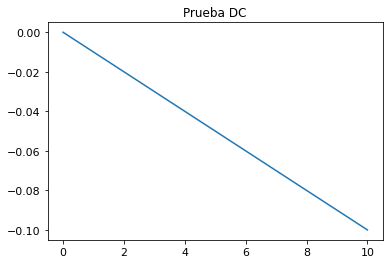

In [17]:
figura = plt.figure()
plt.title("Prueba DC")
plt.plot(resultados['dc']['V1'], resultados['dc']['I(V1)'], label="Voltaje (V1)")


 > **Pregunta:** comenta la gráfica anterior… ¿qué estamos viendo exactamente? Etiqueta los ejes de la misma convenientemente. Así como ningún número puede *viajar* solo sin hacer referencia a su naturaleza, ninguna gráfica puede estar sin sus ejes convenientemente etiquetados. Algo de [ayuda](https://matplotlib.org/3.1.0/gallery/pyplots/fig_axes_labels_simple.html). ¿Qué biblioteca estamos usando para graficar? Una [pista](https://matplotlib.org).

 > **Respuesta:**

 > La gráfica esta mostrando diferencia de potencia (V) en el eje x, y corriente o intensidad (A) en el eje y.

 > Si tomamos los valores como absolutos, puesto que el signo solo representa el sentido del flujo de los electrones, se ve como conforme aumenta la diferencia de potencial aumenta linealmente la corriente, y esto, según la Ley de Ohm debería de pasar a razón de la carga o resistencia. Puesto que la carga de nuestro circuito ofrece una resistencia de $\mathrm{100\Omega}$, para, por ejemplo $\mathrm{4v}$, según la ley de Ohm tendriamos:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{4v}}{\mathrm{100\Omega}}=\mathrm{0.04A}$$

 > Aquí la gráfica con sus ejes convenientemente etiquetados:

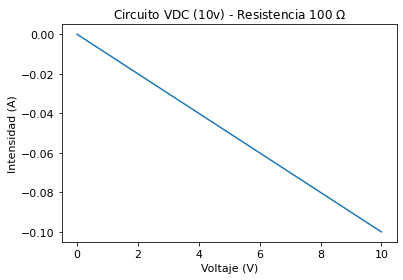

In [18]:
import matplotlib.pyplot as plot
fig, ax = plot.subplots()
ax.plot(resultados['dc']['Vn001'], resultados['dc']['I(V1)'])
ax.set(xlabel='Voltaje (V)', ylabel='Intensidad (A)',
       title='Circuito VDC ($\mathrm{10v}$) - Resistencia $\mathrm{100\ \Omega}$')
plot.show()


  ### Resultados de la simulación `.op`
  El método `.results` nos devuelve un diccionario con los resultados de la simulación.

In [19]:
print(resultados['op'].results)


{VN001: 9.0, I(V1): -0.09}


  > **Pregunta:** justifica el sencillo resultado anterior (análisis `op`). Repite el cálculo con Sympy, atendiendo con mimo a las unidades y al formateo de los resultados (tal y como hemos visto en muchos otros notebooks en clase).

 > **Respuesta:**

 > Puesto que la carga de nuestro circuito ofrece una resistencia de $\mathrm{100\Omega}$, para $\mathrm{9v},$ según la ley de Ohm tendriamos:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{9v}}{100\mathrm{\Omega}}=\mathrm{0.09A}$$

 > Con Sympy:

In [20]:
from sympy.physics.units import amperes, volts, ohms, convert_to
voltaje = 9 * volts
resistencia = 100 * ohms
intensidad = symbols('i')
ley_ohm = Eq(voltaje, resistencia*intensidad)
corriente = solve(ley_ohm, intensidad)
corriente = convert_to(corriente[0], [amperes]).n(2)
print("Si tenemos una fuente de " + str(voltaje) + " y una resistencia de " + str(resistencia) + "\nla intensidad en amperios es:")
corriente


Si tenemos una fuente de 9*volt y una resistencia de 100*ohm
la intensidad en amperios es:


0.09*ampere

 ## Resolución del mismo circuito pero con LTspice
 Por comodidad, creamos un alias del comando que apunte al ejecutable de LTspice. Como es evidente, este paso requiere tener instalado LTspice en la carpeta por defecto.

In [21]:
get_ipython().run_line_magic(
    'alias', 'lts /Applications/LTspice.app/Contents/MacOS/LTspice -ascii -b')
if platform.system() == "Windows":
    get_ipython().run_line_magic(
        'alias', 'lts "C:\\Program Files\\LTC\\LTspiceXVII\\XVIIx64.exe" -ascii -b ')


 > **Pregunta**: ¿Qué significan las opciones `-b` y `-ascii`? Algo de ayuda [aquí](http://ltwiki.org/LTspiceHelp/LTspiceHelp/Command_Line_Switches.htm).

 > **Respuesta:**

 > * `-b` establece la ejecución por lotes. Los datos resultantes se guardarán en un `archivo.raw`
 > * `-ascii` indica que los `archivos.raw` deben de generarse en formato ASCII

 También tenemos que cambiar ligeramente la sintaxis. Ejecuta esta línea para que se escriba el fichero siguiente. Para LTspice, vamos a reservar la extensión `.net`:

In [22]:
%%writefile 'files\circuito_sencillo.net'
* Este es un circuito sencillo adaptado para LTspice
r1 1 0 100
v1 0 1 9
.op
* Comentamos el análisis .dc para centrarnos primero en el .op
* .dc v1 1 10 
.end


Writing files\circuito_sencillo.net


 Ejecutamos LTspice con el circuito (de la misma manera que antes habíamos hecho con Ahkab).

 Pare ello usaremos el alias de ejecutable y le pasamos por parametro el archivo que acabamos de crear.

In [23]:
lts "files\circuito_sencillo.net"


 Esto habrá generado dos archivos, un `.log` y un .raw, con el resultado de la simulación. Veamos su contenido.

 ## Contenido del `.log`:

In [24]:
get_ipython().run_line_magic('pycat', 'files\circuito_sencillo.log')


 ## Contenido del `.raw`:

In [25]:
get_ipython().run_line_magic('pycat', 'files\circuito_sencillo.raw')


 Ahora repitamos lo mismo para el análisis `.dc`:

In [26]:
%%writefile 'files\circuito_sencillo.net'
* Este es un circuito sencillo adaptado para LTspice
r1 1 0 100
v1 0 1 9
* Comentamos el análisis .op para centrarnos primero en el .dc
* .op
.dc v1 1 10 10
.end


Overwriting files\circuito_sencillo.net


In [27]:
lts "files\circuito_sencillo.net"


 Al ejecutar esta simulación para el análisis `.dc`, el fichero `.raw` con los resultados es muchísimo mas extenso. Para leer este fichero, y ademas, extraer los valores para la gráfica vamos a usar el paquete [ltspice de Python](https://github.com/DongHoonPark/ltspice_pytool), el cual se puede  instalar directamente desde Jupyter

In [28]:
get_ipython().system('pip install ltspice')


 Ahora leemos el fichero `.raw` y dibujamos la gráfica con los datos obtenidos con LTspice:

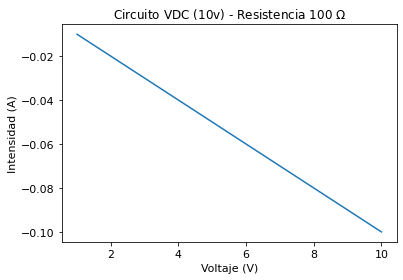

In [29]:
l = ltspice.Ltspice("files\circuito_sencillo.raw")
l.parse()
tiempo = l.get_time()
voltaje = l.get_data('v1')
corriente = l.get_data('I(V1)')

import matplotlib.pyplot as plot
fig, ax = plot.subplots()
ax.set(xlabel='Voltaje (V)', ylabel='Intensidad (A)',
       title='Circuito VDC ($\mathrm{10v}$) - Resistencia $\mathrm{100\ \Omega}$')
ax.plot(voltaje, corriente)
plot.show()


In [30]:
# #################################################################
#  ## Análisis de circuito con resistencias en serie
# #################################################################


  ## Análisis de circuito con resistencias en serie

 Vamos a resolver (en punto de operación) el siguiente circuito, que consta de 3 resistencias en serie de $\mathrm{3k\Omega}$, $\mathrm{10k\Omega}$ y $\mathrm{5k\Omega}$ respectivamente:

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20serie.svg?sanitize=true)

 Al igual que antes, grabamos el netlist en disco desde Jupyter con los datos representativos del circuito comentado. Para ello usamos la *palabra mágica* [`%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile). Más info [aquí](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile).

In [31]:
%%writefile "files\resistencias_en_serie.net"
* circuito con tres resistencias en serie
v1 1 0 type=vdc vdc=9
R1 0 2 3k
R2 2 3 10k  
R3 3 1 5k
* análisis del circuito
.op
.end


Writing files\resistencias_en_serie.net


 Haciendo uso de la librería `Ahkab` procesamos el circuito que acabamos de definir.

In [32]:
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    'files\\resistencias_en_serie.net')


 El método `ahkab.netlist_parser.parse_circuit()` ha creado una lista en cuya primera posición se ha guardado la lista de componentes y sus conexiones, y en la segunda posición, la listas de analisis que se quieren realizar durante la simulación.

 Extraemos estos datos a sendas variables.

In [33]:
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]


 Ahora con el método `ahkab.netlist_parser.parse_analysis()` generamos una lista con las operaciones de analisis que se realizaran durante la simulación. Cada elemento de la lista contendrá el tipo de analisis a realizar (dc, tran, etc.) y los parametros con los que se realizará cada analisis.

In [34]:
lista_de_análisis = ahkab.netlist_parser.parse_analysis(
    netlist, análisis_en_netlist)
print(lista_de_análisis)


[{'type': 'op', 'guess': True, 'x0': None}]


 Podemos usar lo que hemos definido durante el circuito anterior para añadir el archivo temporal `.tsv` si fuera necesario, aunque ahora no haría falta, puesto que no hemos establecido ningún analisis `.dc` ni `.tran`

In [35]:
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"


 Ya tenemos lo necesario para ejecutar las simulaciones. Esto lo haremos usando el método `.run` de Ahkab

In [36]:
resultados = ahkab.run(netlist, lista_de_análisis)


Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimos los resultados del análisis `.op`:

In [37]:
print(resultados['op'])


OP simulation results for '* circuito con tres resistencias en serie'(netlist files\resistencias_en_serie.net).
Run on 2020-12-19 12:32:54, data file None.
Variable    Units      Value     Error    %
----------  -------  -------  --------  ---
V1          V         9       -9e-12      0
V2          V         1.5     -1.5e-12    0
V3          V         6.5     -6.5e-12    0
I(V1)       A        -0.0005   0          0


 Los valores `V1`, `V2` y `V3` representan la diferencia de potencial (V) que hay entre los bornes de las conexiones `1`, `2` y `3` definidas en el netlist y masa, que es el borne `0`, es decir, la conexión entre la pila y `R1`:
 >```spice
 v1 1 0 type=vdc vdc=9
 R1 0 2 3k
 R2 2 3 10k
 R3 3 1 5k
 ```

 * `V1` es la diferencia de potencial entre la conexión de la pila con `R3` y masa.
 * `V2` es la diferencia de potencial entre la conexión de `R1` con `R2` y masa.
 * `V3` es la diferencia de potencial entre la conexión de `R2` con `R3` y masa.

 ### **Ejercicio**:

 Comprueba que podemos calcular el *potencial consumido* por la resistencia `R1` y verás que coincide con el del punto `V2` devuelto por Ahkab.

 ### **Respuesta**:

 Huelga decir que la carga de dos resistencias en serie es la suma de sus cargas, por lo que podríamos tratar el circuito como si de dos resistencias en serie se tratara. Una sería `R1` $\mathrm{(3k\Omega)}$ y la otra la suma de `R2`+`R3` $(\mathrm{10k\Omega}+\mathrm{5k\Omega}=\mathrm{15k\Omega})$ y la carga total sería `R1`+`R2`+`R3` $(\mathrm{3k\Omega}+\mathrm{10k\Omega}+\mathrm{5k\Omega}=\mathrm{18k\Omega})$

 Si calculamos manualmente la corriente, sabiendo que tenemos una diferencia de potencial de $\mathrm{9v}$ a los extremos de la pila, tenemos que:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{9v}}{\mathrm{18k\Omega}}=\mathrm{0.5\ mA}$$
 Que se corresponde con los $\mathrm{0.0005\ A}$ que nos ha devuelto `Ahkab` para `I(V1)`

 Puesto que las resistencias están en serie, el flujo de electrones en cada resistencia debe de ser el mismo, en concreto el equivalente a $\mathrm{0.5\ mA}$. Por tanto podemos calcular la caída de potencial en cada resistencia.

 $$\mathrm{V_1}=\mathrm{R_1}\cdot\mathrm{I}=\mathrm{3k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{1.5v}$$
 $$\mathrm{V_2}=\mathrm{R_2}\cdot\mathrm{I}=\mathrm{10k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{5v}$$
 $$\mathrm{V_3}=\mathrm{R_3}\cdot\mathrm{I}=\mathrm{5k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{2.5v}$$

 Como se puede observar, la suma de las caídas de potencial es exactamente la diferencia de potencial en los extremos de la pila, que también son los extremos de las tres resistencias.
 $$\mathrm{V}=\mathrm{V_1}+\mathrm{V_2}+\mathrm{V_3}=\mathrm{1.5v}+\mathrm{5v}+\mathrm{2.5v}=\mathrm{9v}$$

 #### Comprobemos si coincide lo que dice `Ahkab` y `V2` es $\mathrm{1.5v}$.

 La suma de las caídas de potencial de las resistencias `R2`+`R3` es $\mathrm{5v}+\mathrm{2.5v}=\mathrm{7.5v}$.

 ### ¿Porque no coincide?
 Si nos fijamos bien en el netlist:
 >```spice
 v1 1 0 type=vdc vdc=9
 R1 0 2 3k
 R2 2 3 10k
 R3 3 1 5k
 ```

 Vemos que el orden en el que se han definido las resistencias es este:

 `+Vcc` )---**1**---( `R3` )---**3**---( `R2` )---**2**---( `R1` )---**0**---( `Gnd`

 Aquí el borne 2 tiene entre él y masa únicamente a `R1`. Según nuestros cálculos la caída de potencial en `R1` es de $=\mathrm{1.5v}$ y si que coincide con lo que dice `Ahkab` para `V2`, que es $\mathrm{1.5v}$

 ### Entonces, ¿Dónde está el error?
 Si observamos el esquema:

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20serie.svg?sanitize=true)

 Primer fallo. No coincide el orden de las resistencias con el del netlist. El orden sería este:

  `+Vcc` )---**1**---( `R1` )---**3**---( `R2` )---**2**---( `R3` )---**0**---( `Gnd`

 Pero ademas, para el cálculo hemos interpretado que entre el borne 2 y masa había dos resistencias, por lo que el orden correcto de las resistencias y de las conexiones para que se ajuste a los cálculos sería este:

  `+Vcc` )---**1**---( `R1` )---**2**---( `R2` )---**3**---( `R3` )---**0**---( `Gnd`

 ### Vamos a comprobarlo

 Volvemos a definir el netlist, esta vez para el orden coincida con los cálculos que hemos realizado.

 `v1` )---**1**---( `R1` )---**2**---( `R2` )---**3**---( `R3` )---**0**---( `v1`
 >```spice
 v1 1 0 type=vdc vdc=9
 R1 1 2 3k
 R2 2 3 10k
 R3 3 0 5k
 ```

In [38]:
%%writefile "files\resistencias_en_serie.net"
* circuito con tres resistencias en serie
v1 1 0 type=vdc vdc=9 
R1 1 2 3k  
R2 2 3 10k    
R3 3 0 5k  
* análisis del circuito
.op
.end


Overwriting files\resistencias_en_serie.net


 Volvemos a procesar el circuito con `Ahkab` y extraemos los datos.

In [39]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    'files\\resistencias_en_serie.net')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los ánalisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"



 Ejecutamos las simulaciones para el nuevo circuito y mostramos el resultado de la simulación `.op`.

In [40]:

print(resultados['op'])


OP simulation results for '* circuito con tres resistencias en serie'(netlist files\resistencias_en_serie.net).
Run on 2020-12-19 12:32:54, data file None.
Variable    Units      Value     Error    %
----------  -------  -------  --------  ---
V1          V         9       -9e-12      0
V2          V         1.5     -1.5e-12    0
V3          V         6.5     -6.5e-12    0
I(V1)       A        -0.0005   0          0


 ### FANTÁSTICO !!!
 Ahora si coinciden los resultados. Podemos ver que `V2` corresponde con la caída cálculada. Además, también V3 coincide con la caída cálcula para la R3 que era de $\mathrm{2.5v}$

 ### Comprobamos con Sympy
 Comprobamos con Sympy que para la corriente obtenida de la simulación, una resistencia de $\mathrm{3k\Omega}$ provoca una caída de potencial de $\mathrm{1.5v}$

In [41]:
r1 = 3E3*ohms
int=resultados['op']['I(V1)']
intensidad_ahkab = resultados['op']['I(V1)'][0][0]*amperes
v2 = convert_to(intensidad_ahkab*r1, [volts])
v2


-1.5*volt

 ### **Pregunta**:

 > Reproduce el resto de los valores anteriores de manera *manual* mediante Sympy (es decir, aplicando la ley de Ohm, pero con un *toque computacional*). Te pongo aquí un ejemplo del que puedes partir… En él sólo calculo la corriente que circula por el circuito (sí, justo la que antes Ahkab ha devuelto de manera automática). Para ello necesito previamente computar la resistencia total (`r_total`). Faltarían el resto de resultados y convertirlos a unidades más *vistosas* (mediante la orden `convert_to` y `.n()`).

In [42]:
v1 = 9*volts
r1 = 3*kilo*ohms
r2 = 10*kilo*ohms
r3 = 5*kilo*ohms
r_total = r1 + r2 + r3
intensidad = symbols('i')
ley_ohm = Eq(v1, intenstensidad)
convert_to(solucion_para_intensidad[0], [amperes]).n(2)


NameError: name 'intenstensidad' is not defined

 ### **Respuesta**:
 Supondrémos el orden de las resistencias igual que el del circuito del esquema, es decir, igual que el de los cálculos que hemos hecho a mano.

In [ ]:
print("Voltaje entre extremos de R1:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r1)
solucion_para_voltaje_R1 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R1[0], [volts]).n(2)


In [ ]:
print("Voltaje entre extremos de R2:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r2)
solucion_para_voltaje_R2 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R2[0], [volts]).n(2)


In [ ]:
print("Voltaje entre extremos de R3:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r3)
solucion_para_voltaje_R3 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R3[0], [volts]).n(2)


In [ ]:
print("Voltaje entre conexión R1-R2 y masa:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*(r2+r3))
solucion_para_voltaje_R2_masa = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R2_masa[0], [volts]).n(2)


In [ ]:
print("Voltaje entre VCC y conexión R2-R3:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*(r1+r2))
solucion_para_voltaje_VCC_R3 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_VCC_R3[0], [volts]).n(2)


 ### **Pregunta**:
 > Demuestra que se cumple la Ley de Kirchhoff de la energía en un circuito, es decir, que la suma de la energía suministrada por las fuentes (pilas) es igual a la consumida por las resistencias. Realiza la operación con Sympy.

 > $$
 \sum_i^N V_{\text{fuentes}} = \sum_j^M V_{\text{consumido en resistencias}}
 > $$
 > Ten en cuenta que en este caso sólo hay una fuente.

 ### **Respuesta**:
 Vaya, parece que nos adelantado a este punto, la respuesta a esto esta en el apartado anterior. Podemos comprovar que la suma de los voltajes en cada resistencia es igual al voltaje suministrado por la pila.

In [ ]:
print("Suma de los voltajes de cada resistencia:")
voltaje_resistencias = solucion_para_voltaje_R1[0] + solucion_para_voltaje_R2[0] + solucion_para_voltaje_R3[0]
convert_to(voltaje_resistencias, [volts]).n(2)


 ## Análisis `.op` de circuitos con resistencias en paralelo

 Vamos a complicar un poco el trabajo añadiendo elementos en paralelo.

  > **Pregunta**: realiza los análisis `.op` de los siguientes circuitos.
  Para ello crea un netlist separado para cada uno donde queden correctamente descritos
  junto con la simulación (`.op`). Comenta los resultados que devuelve Ahkab (no imprimas los resultados de las simulaciones *sin más*).

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20paralelo.svg?sanitize=true)

  Aquí tienes el análisis del primer circuito, para que sirva de ejemplo:

 ### **Análisis del primer circuito**

  ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_paralelo_1_lab_fisica.svg?sanitize=true)

 Definimos el netlist del primer circuito paralero.

In [ ]:
%%writefile "files\resistencias_en_paralelo_1.cir"
* resistencias en paralelo
vdd 0 1 vdc=12 type=vdc
r2 1 2 1k
r3 2 3 220
r4 3 0 1.5k
r5 2 0 470
.op
.end


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [ ]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    'files\\resistencias_en_paralelo_1.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(
    netlist, análisis_en_netlist)
resultados = ahkab.run(netlist, lista_de_análisis)
# Establecer condiciones óptimas para los ánalisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"


 Imprimimos los resultados del análisis `.op`. Como puedes comprobar, Ahkab sólo reporta la intensidad de corriente en las ramas en las que hay una pila (en este caso, la rama donde está la pila `VDD`).

In [ ]:
print(resultados['op'])


 ### **Pregunta:**

 > Inserta dos *pilas virtuales* de 0 voltios en el resto de ramas del circuito (`Vdummy1` en la rama donde está `R5` y `Vdummy2` en la rama donde está `R3` y `R4`) para que Ahkab nos imprima también la corriente en las mismas. Es muy parecido al tercer circuito que tienes que resolver, donde `V1`, `V2` y `V3` tienen cero voltios. Estas *pilas nulas* son, a todos los efectos, *simples cables*. Una vez que ya tienes las corrientes en todas las ramas, comprueba que se cumple la Ley de Kirchhoff para las corrientes:

 > $$
 I_{\text{entrante}} = \sum_i^{N} I_{\text{salientes}}
 $$

 > Repite lo mismo para los otros dos circuitos. Realiza además los cálculos con Sympy (recalcula los mismos voltajes que devuelve Ahkab a partir de la corriente que sí te devuelve la simulación) y cuidando de no olvidar las unidades. Recuerda que el objeto `resultados` alberga toda la información que necesitas de manera indexada. Ya han aparecido un ejemplo más arriba. Es decir: no *copies* los números *a mano*, trabaja de manera informáticamente elegante (usando la variable `resultados`).

 ### **Respuesta**
 Definimos el netlist con las dos pilas de $\mathrm{0v}$

In [ ]:
%%writefile "files\resistencias_en_paralelo_1.cir"
* resistencias en paralelo
vdd 1 0 vdc=12 type=vdc
Vdummy1 4 0 vdc=0 type=vdc
Vdummy2 5 0 vdc=0 type=vdc
r2 1 2 1k
r3 2 3 220
r4 3 5 1.5k
r5 2 4 470
.op
.end


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [ ]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    'files\\resistencias_en_paralelo_1.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(
    netlist, análisis_en_netlist)
resultados = ahkab.run(netlist, lista_de_análisis)
# Establecer condiciones óptimas para los ánalisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"


 Imprimimos los resultados del análisis `.op`.

In [ ]:
print(resultados['op'])


 Como poemos ver la suma de las corrientes de las pilas dummy es igual a la corriente total. Comprobemoslos.

 La corriente total es:

In [ ]:
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes
convert_to(intensidad, [amperes]).n(5)


 La suma de las corrientes de la pilas dummy es:

In [ ]:
intensidad_dummy1 = resultados['op'].results._dict['I(VDUMMY1)']*amperes
intensidad_dummy2 = resultados['op'].results._dict['I(VDUMMY2)']*amperes
convert_to(intensidad_dummy1+intensidad_dummy2, [amperes]).n(5)


 GENIAL !!! Se cumple la Ley de Kirchhoff

 ### Comprobemos el resultado de `Ahkab` con Sympy
 Ahora tenemos resistencias en paralelo, por lo que ya no podemos sumar sus resistencias para aberiguar la resistencia total del circuito.

 ¿Como afecta la carga resistiva de dos resistencias en paralelo a la carga total?

 Antes de responder a esta pregunta calculemos la resistencia total con los datos de los que disponemos.

 Nótese que no existen resistencias negativas, ya que son componentes pasivos. Puesto que `Ahkab` nos esta dando la corriente en negativo, le invertimos el signo para que la resistencia resulte positiva.

In [ ]:
v1 = 12*volts
r2 = 1*kilo*ohms
r3 = 220*ohms
r4 = 1.5*kilo*ohms
r5 = 470*ohms
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes 
resistencia = symbols('r')
ley_ohm = Eq(v1, intensidad*resistencia)
resistencia_total = solve(ley_ohm, resistencia)
convert_to(resistencia_total[0], [ohms]).n(5)


 Como ya sebemos, la resistencia total de cargas en serie es la suma de sus resistencias. Ahora que conocemos la resistencia total, la resistencia equivalente de las dos mallas formadas por `R3`, `R4` y `R5`, solo puede ser la resistencia total menos la resistencia de `R2`

In [ ]:
r_subcircuito = resistencia_total[0] - r2
convert_to(r_subcircuito, [ohms]).n(5)


 Gracias a `Ahkab` conocemos la corriente total y también el voltaje en el borne 2. Comprobemos con estos datos que la resistencia que acabamos de obtener es correcta.

In [ ]:
v = resultados['op'].results._dict['V2']*volts
i = -resultados['op'].results._dict['I(VDD)']*amperes 
resistencia = symbols('r')
ley_ohm = Eq(v, i*resistencia)
r_subcircuito = solve(ley_ohm, resistencia)
convert_to(r_subcircuito[0], [ohms]).n(5)


 Conocemos la resistencia de cada maya, ya que una es `R5` y la otra `R3`+`R4`. Esto es $R_{m1}=\mathrm{470\ \Omega}$ y $R_{m2}=\mathrm{1720\ \Omega}$, pero la la resistencia equivalente es inferior a la de cualquiera de las dos mallas. ¿Porque? ¿Que está pasando?

 Veámoslo con números mas redondos. Supongamos que una pila de $\mathrm{10\ v}$ aporta una corriente de $\mathrm{1\ A}$ a un circuito con dos cargas en paralelo, de las que no conocemos sus resistencias, pero sabemos que son iguales.

 La resistencia equivalente sería $\frac{\mathrm{10\ v}}{\mathrm{1\ A}}=\mathrm{10\ \Omega}$

 Para que se cumpla la Ley de Kirchhoff, por cada rama deben circular $\mathrm{0.5\ A}$, por tanto la resistencias serán de $\mathrm{20\ \Omega}$

 Vaya!!! la resistencia equivalente es justo la mitad del valor de las resistencias si esta son iguales. Esto es porque para que se cumpla la Ley de Kirchhoff, el flujo de electrones se tiene que repartir entre cada malla proporcionalmente a su resistencia, y como ya hemos visto por la ley de Ohm, esto sucede con una proporcionalidad lineal. Por lo que la inversa de la resistencia equivalente sera igual a la suma de las inversas de cada malla.

 Comprobemos esto con los datos que tenemos del circuito.

In [ ]:
inv_malla1 = 1/r5
inv_malla2 = 1/(r3+r4)
equiv = symbols('equiv')
equiv = solve(1/equiv-inv_malla1-inv_malla2, equiv)
convert_to(equiv[0], [ohms]).n(5)


 Nos falta por comprobar los voltajes de cada nodo.

In [ ]:
print("Voltaje en el nodo 2:")
v = symbols('v')
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes 
ley_ohm = Eq(v, intensidad*equiv[0])
voltaje_V2 = solve(ley_ohm, v)
convert_to(voltaje_V2[0], [volts]).n(3)


In [ ]:
print("Voltaje en el nodo 3:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_dummy2*r4)
voltaje_V3 = solve(ley_ohm, v)
convert_to(voltaje_V3[0], [volts]).n(3)

























In [ ]:
# ###############################################################
# Circuito paralelo 2
# ###############################################################


 ### **Análisis del segundo circuito**

  ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_paralelo_2_lab_fisica.svg?sanitize=true)

 Definimos el netlist del segundo circuito paralero. Nos adelantamos y colocamos una pila de $\mathrm{0\ v}$ en la malla de las tres resistencias en serie.

In [ ]:
%%writefile "files\resistencias_en_paralelo_2.cir"
* resistencias en paralelo
v1 1 0 vdc=9 type=vdc
v2 4 0 vdc=1.5 type=vdc
vdummy 6 0 vdc=0 type=vdc
r1 1 2 47
r2 2 3 220
r3 2 4 180
r4 3 5 1k
r5 5 6 560
.op
.end


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [ ]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(
    'files\\resistencias_en_paralelo_2.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(
    netlist, análisis_en_netlist)
resultados = ahkab.run(netlist, lista_de_análisis)
# Establecer condiciones óptimas para los ánalisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"


 Imprimimos los resultados del análisis `.op`.

In [ ]:
print(resultados['op'])


 Comprobamos que se cumple la Ley de Kirchhoff para las corrientes

 La corriente total es:

In [ ]:
intensidad_total = -resultados['op'].results._dict['I(V1)']*amperes
convert_to(intensidad_total, [amperes]).n(5)


 La suma de las corrientes de las mallas es:

In [ ]:
intensidad_malla1 = resultados['op'].results._dict['I(V2)']*amperes
intensidad_malla2 = resultados['op'].results._dict['I(VDUMMY)']*amperes
convert_to(intensidad_malla1+intensidad_malla2, [amperes]).n(5)


 GENIAL !!! Se cumple la Ley de Kirchhoff

 ### Comprobemos los resultados de `Ahkab` con Sympy

In [ ]:
v1 = 9*volts
v2 = 1.5*volts
r1 = 47*ohms
r2 = 220*ohms
r3 = 180*ohms
r4 = 1*kilo*ohms
r5 = 560*ohms
resistencia = symbols('r')
ley_ohm = Eq(v1, intensidad_total*resistencia)
resistencia_total = solve(ley_ohm, resistencia)
print("La resistencia total del circuito es:")
convert_to(resistencia_total[0], [ohms]).n(5)


 No podemos calcular la resistencia equivalente de las dos mallas en paralelo, usando las inversas de las resistencias, como lo hemos hecho en el circuito anterior, porque hay una pila con con tensión en una de las mallas y esto provoca que no haya la misma diferencia de potencial en las dos mallas.

 Pero podemos calcularla conociendo la resistencia total y la resistencia de `r1`

In [ ]:
print("La resistencia equivalente de las dos malla en paralelo es:")
equiv = resistencia_total[0] - r1
convert_to(equiv, [ohms]).n(5)


In [ ]:
print("La diferencia de potencial en V2 es:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_total*r1)
# calcular la tension entre extremos de r1
voltaje_R1 = solve(ley_ohm, v)
voltaje_V2 = v1-voltaje_R1[0]
convert_to(voltaje_V2, [volts]).n(3)


In [ ]:
print("La diferencia de potencial en V3 es:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_malla2*(r4+r5))
voltaje_V3 = solve(ley_ohm, v)
convert_to(voltaje_V3[0], [volts]).n(3)


In [ ]:
print("La diferencia de potencial en V4 es:")
voltaje_V4 = v2
convert_to(voltaje_V4, [volts]).n(3)


In [ ]:
print("La diferencia de potencial en V5 es:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_malla2*r5)
voltaje_V5 = solve(ley_ohm, v)
convert_to(voltaje_V5[0], [volts]).n(3)








 Puesto que no sabemos como esta afectando la pila que hay en serie con `R3`, es mas sencillo calcular la tensión en el nodo 2, restando a `v1` la diferencia de potencial entre extremos de `R1`.

In [ ]:
print("La diferencia de potencial en V2 es:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_total*r1)
# calcular la tension entre extremos de r1
voltaje_R1 = solve(ley_ohm, v)
voltaje_V2 = v1-voltaje_R1[0]
convert_to(voltaje_V2, [volts]).n(3)


In [ ]:
resultados['op'].results._dict['V2']*volts


 Puesto que no sabemos como esta afectando la pila que hay en serie con `R3`, es mas sencillo calcular la tensión en el nodo 2, restando a `v1` la diferencia de potencial entre extremos de `R1`.

 La diferencia de potencial en V2 según `Ahkab` es:

In [ ]:
resultados['op'].results._dict['V2']*volts

 Comprobamos diferencia de potencial en V2 con Sympy:

In [ ]:
v = symbols('v')
ley_ohm = Eq(v, intensidad_total*r1)
# calcular la tension entre extremos de r1
voltaje_R1 = solve(ley_ohm, v)
voltaje_V2 = v1-voltaje_R1[0]
convert_to(voltaje_V2, [volts]).n(3)


 Para calcula la diferencia de potencial en V3 aplicamos la *Ley de Ohm* para la corriente devuelta por `Ahkab` para la pila dummy y la suma de las resistencias `R4` y `R5`.

 La diferencia de potencial en V3 según `Ahkab` es:

In [ ]:
resultados['op'].results._dict['V3']*volts
